--------

## BRASIC - Fuzzy C-Means

Alunos: **Jorge Nery** 

Data: 10/04/2025

## Preparação Ambiente

In [1]:
# !pip install grakel
# !pip install geopy 

### Libraries

In [2]:
# Carregando Bibliotegas e Funções
import os
import random
import requests
import pandas as pd
import numpy as np
import csv
import math
import time
from folium import plugins
import branca
from sklearn.metrics import pairwise_distances
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from folium.plugins import Fullscreen
from branca.colormap import linear
import json
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.distance import great_circle
import networkx as nx
from grakel import GraphKernel
from grakel import graph_from_networkx
import pickle
import duckdb
import core.commons as commons
import core.measures as measures

d:\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
dataset_path = 'datasets'
route_short_name = '0116'
trips = os.path.join(dataset_path, 'gps_trips_30-08-2024_30-08-2024.parquet')
df_stun = commons.stun_paradas_por_rota(trips, route_short_name)
#grafo_stun = pontoslinha_to_grafo(df_stun)
#show_grafo(grafo_stun)
# df_stun.head(5)
# Definir ponto inicial e final com base na primeira e última linha
df_stun = commons.inclui_sentido(df_stun)
df_stun.head(3)

route_id route_short_name route_long_name  stop_sequence  direction_id  \
0     0116             0116            0116              1             0   
1     0116             0116            0116              2             0   
2     0116             0116            0116              3             0   

    stop_id                                          stop_name zone_id  \
0  43768720  Avenida Vale Do Tororo 327, Salvador - Bahia, ...           
1  45832898  Avenida Vale do Tororó, 291 - Nazaré, Salvador...           
2  44782328  Praça Dr. João Mangabeira, 627-679 - Garcia, S...           

    stop_lat   stop_lon sentido_detectado  
0 -12.983389 -38.511230                 0  
1 -12.986428 -38.511097                 0  
2 -12.990091 -38.511448                 0

In [4]:
gtfs_path = 'datasets\GTFS_OTTRANS.zip'
# route_short_name = '1317'
route_short_name = 'Todas'
df_gtfs = commons.carregar_paradas_por_rota(gtfs_path, route_short_name)
#grafo_gtfs = pontoslinha_to_grafo(df_gtfs)
#show_grafo(grafo_gtfs)
df_gtfs
tp = (df_gtfs[df_gtfs['stop_sequence']==1]['stop_lat'].values[0], df_gtfs[df_gtfs['stop_sequence']==1]['stop_lon'].values[0])  # ponto inicial
max_seq = df_gtfs['stop_sequence'].max()
ts = (df_gtfs[df_gtfs['stop_sequence']==max_seq]['stop_lat'].values[0], df_gtfs[df_gtfs['stop_sequence']==max_seq]['stop_lon'].values[0])  # ponto final

df_gtfs['sentido_detectado'] = df_gtfs.apply(
    lambda row: commons.detectar_sentido(
        [ row, df_gtfs.iloc[row.name - 1] if row.name > 0 else None, df_gtfs.iloc[row.name - 2] if row.name > 1 else None],
        tp,
        ts
    ),
    axis=1
)
df_gtfs.head(3)

route_id route_short_name route_long_name  stop_sequence  direction_id  \
0    27891             0116      Lapa x HGE              1             0   
1    27891             0116      Lapa x HGE              1             1   
2    27891             0116      Lapa x HGE              2             1   

    stop_id                                          stop_name zone_id  \
0  43768720  Avenida Vale Do Tororo 327 Salvador - Bahia 40...     nan   
1  44423222  Ladeira do Hospital Geral 630-654 - Brotas Sal...     nan   
2  44783187  Ladeira do Hospital Geral 163-339 - Brotas Sal...     nan   

    stop_lat   stop_lon sentido_detectado  
0 -12.983389 -38.511230                 0  
1 -12.995110 -38.489471                 0  
2 -12.995879 -38.490166                 0

### Funçõe de Mapa

In [5]:
import core.plot as plot

In [6]:
df_shape = commons.carregar_shapes_por_rota(gtfs_path, '0116')
df_shape.head(3)

route_id route_short_name route_long_name  stop_sequence stop_name zone_id  \
0     27891             0116      Lapa x HGE              0                     
1     27891             0116      Lapa x HGE              1                     
2     27891             0116      Lapa x HGE              2                     

   direction_id  stop_id   stop_lat   stop_lon  
0             0  53786_I -12.983381 -38.511204  
1             0  53786_I -12.983274 -38.511215  
2             0  53786_I -12.983094 -38.511436

In [7]:
df_tudo = pd.concat([df_stun, df_gtfs, df_shape], ignore_index=True)
df_shape[df_shape["route_short_name"] == '0116'].sort_values(
            by=["direction_id","stop_sequence"]
        )


route_id route_short_name route_long_name  stop_sequence stop_name  \
0       27891             0116      Lapa x HGE              0             
1       27891             0116      Lapa x HGE              1             
2       27891             0116      Lapa x HGE              2             
3       27891             0116      Lapa x HGE              3             
4       27891             0116      Lapa x HGE              4             
..        ...              ...             ...            ...       ...   
256     27891             0116      Lapa x HGE             88             
257     27891             0116      Lapa x HGE             89             
258     27891             0116      Lapa x HGE             90             
259     27891             0116      Lapa x HGE             91             
260     27891             0116      Lapa x HGE             92             

    zone_id  direction_id  stop_id   stop_lat   stop_lon  
0                       0  53786_I -12.983381 -38.511204  
1                       0  53786_I -12.983274 -38.511215  
2                       0  53786_I -12.983094 -38.511436  
3                       0  53786_I -12.982587 -38.512024  
4                       0  53786_I -12.982397 -38.511837  
..      ...           ...      ...        ...        ...  
256                     1  53786_V -12.984189 -38.510582  
257                     1  53786_V -12.984039 -38.510723  
258                     1  53786_V -12.983747 -38.511036  
259                     1  53786_V -12.983615 -38.511177  
260                     1  53786_V -12.983381 -38.511192  

[261 rows x 10 columns]

In [261]:
linhas_selecionadas = df_gtfs.route_short_name.unique()[0:20]
plot.desenha_mapa_pydeck(linhas=[df_gtfs[df_gtfs['route_short_name'].isin(linhas_selecionadas)]],)


{
  "initialViewState": {
    "latitude": -12.97081107902527,
    "longitude": -38.48953900527954,
    "zoom": 13
  },
  "layers": [
    {
      "@@type": "PathLayer",
      "autoHighlight": true,
      "data": [
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.51123046875,
              -12.9833889007568
            ],
            [
              -38.5110969543457,
              -12.9864282608032
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.5110969543457,
              -12.9864282608032
            ],
            [
              -38.5114479064941,
              -12.9900913238525
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.5114479064941,
              -12.9900913238525
            ],
            [
              -38.5043869018555,
              -12.990532875061
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.5043869018555,
              -12.990532875061
            ],
            [
              -38.5019721984863,
              -12.9920053482056
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.5019721984863,
              -12.9920053482056
            ],
            [
              -38.4990043640137,
              -12.9933242797852
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.4990043640137,
              -12.9933242797852
            ],
            [
              -38.4970016479492,
              -12.9951114654541
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.4970016479492,
              -12.9951114654541
            ],
            [
              -38.4955520629883,
              -12.9962129592896
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.4955520629883,
              -12.9962129592896
            ],
            [
              -38.4902191162109,
              -12.9960737228394
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": [
            207,
            182,
            59
          ],
          "path": [
            [
              -38.4902191162109,
              -12.9960737228394
            ],
            [
              -38.4892272949219,
              -12.9950456619263
            ]
          ],
          "tooltip": "\n                <b>Linha:</b> 0116 - <b>Sentido:</b> 0\n            "
        },
        {
          "color": 

In [9]:
import core.plot as plot


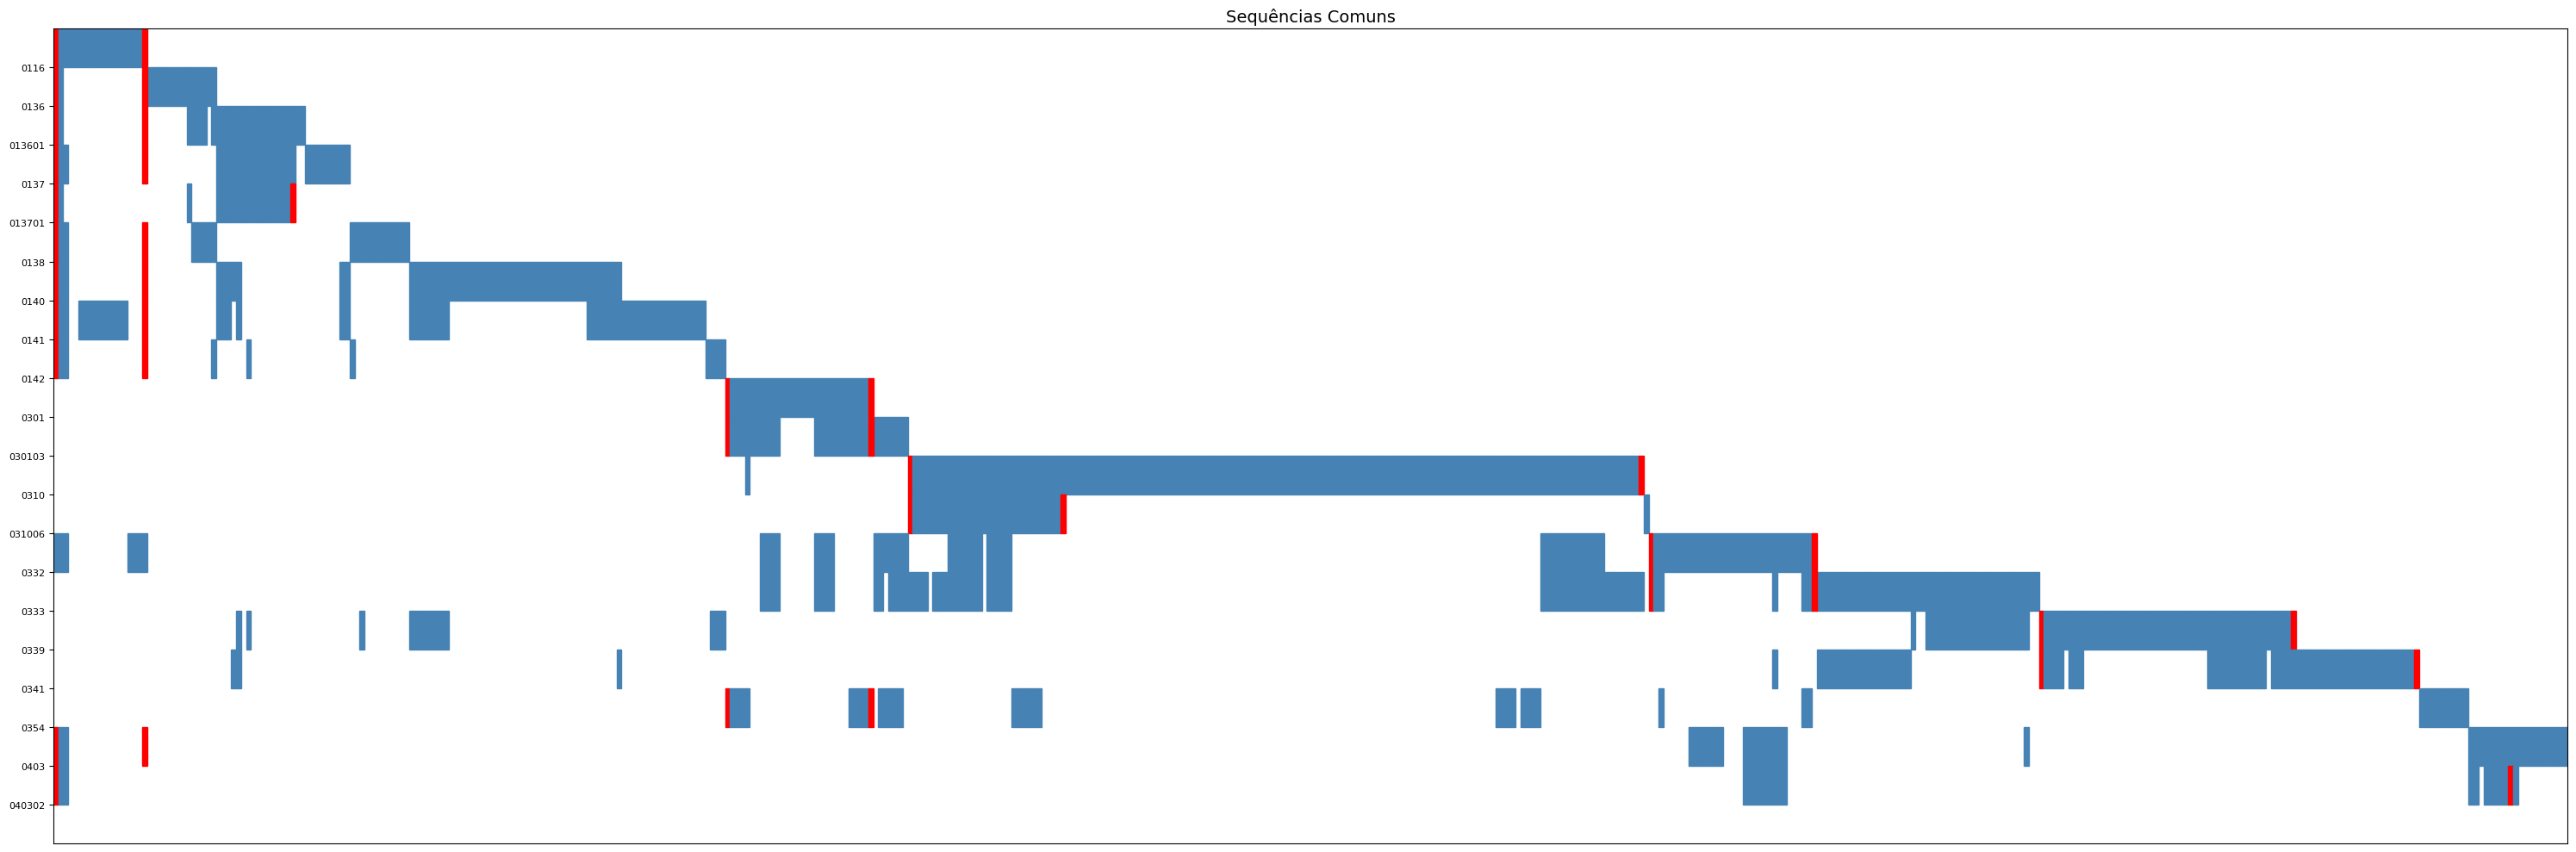

In [262]:
exemplo1 = df_gtfs[df_gtfs['route_short_name'].isin(linhas_selecionadas)].copy()
#exemplo2 = exemplo1.copy()
#exemplo2['route_short_name'] = exemplo2['route_short_name'].astype(str) + 'B'
plot.plot_routes_map([exemplo1],type='lcs', vis_seq=False, vis_pontos=False)


In [263]:
df_gtfs.sort_values(by=['direction_id','stop_sequence'], inplace=True)
df_gtfs.head(1)

route_id route_short_name route_long_name  stop_sequence  direction_id  \
0    27891             0116      Lapa x HGE              1             0   

    stop_id                                          stop_name zone_id  \
0  43768720  Avenida Vale Do Tororo 327 Salvador - Bahia 40...     nan   

    stop_lat  stop_lon sentido_detectado  
0 -12.983389 -38.51123                 0

In [270]:
#grafos = commons.rotas_to_grafo(exemplo1)
grafos = commons.rotas_to_grafo(df_gtfs)
len(grafos)

236

In [271]:
matrix = measures.matriz_similaridade(grafos, func_similaridade=measures.jaccard_similarity)
matrix

array([[1.        , 0.        , 0.        , ..., 0.00554017, 0.        ,
        0.00288184],
       [0.        , 1.        , 0.        , ..., 0.05084746, 0.        ,
        0.2247191 ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00554017, 0.05084746, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.00288184, 0.2247191 , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### Determinando Numero de Clusters

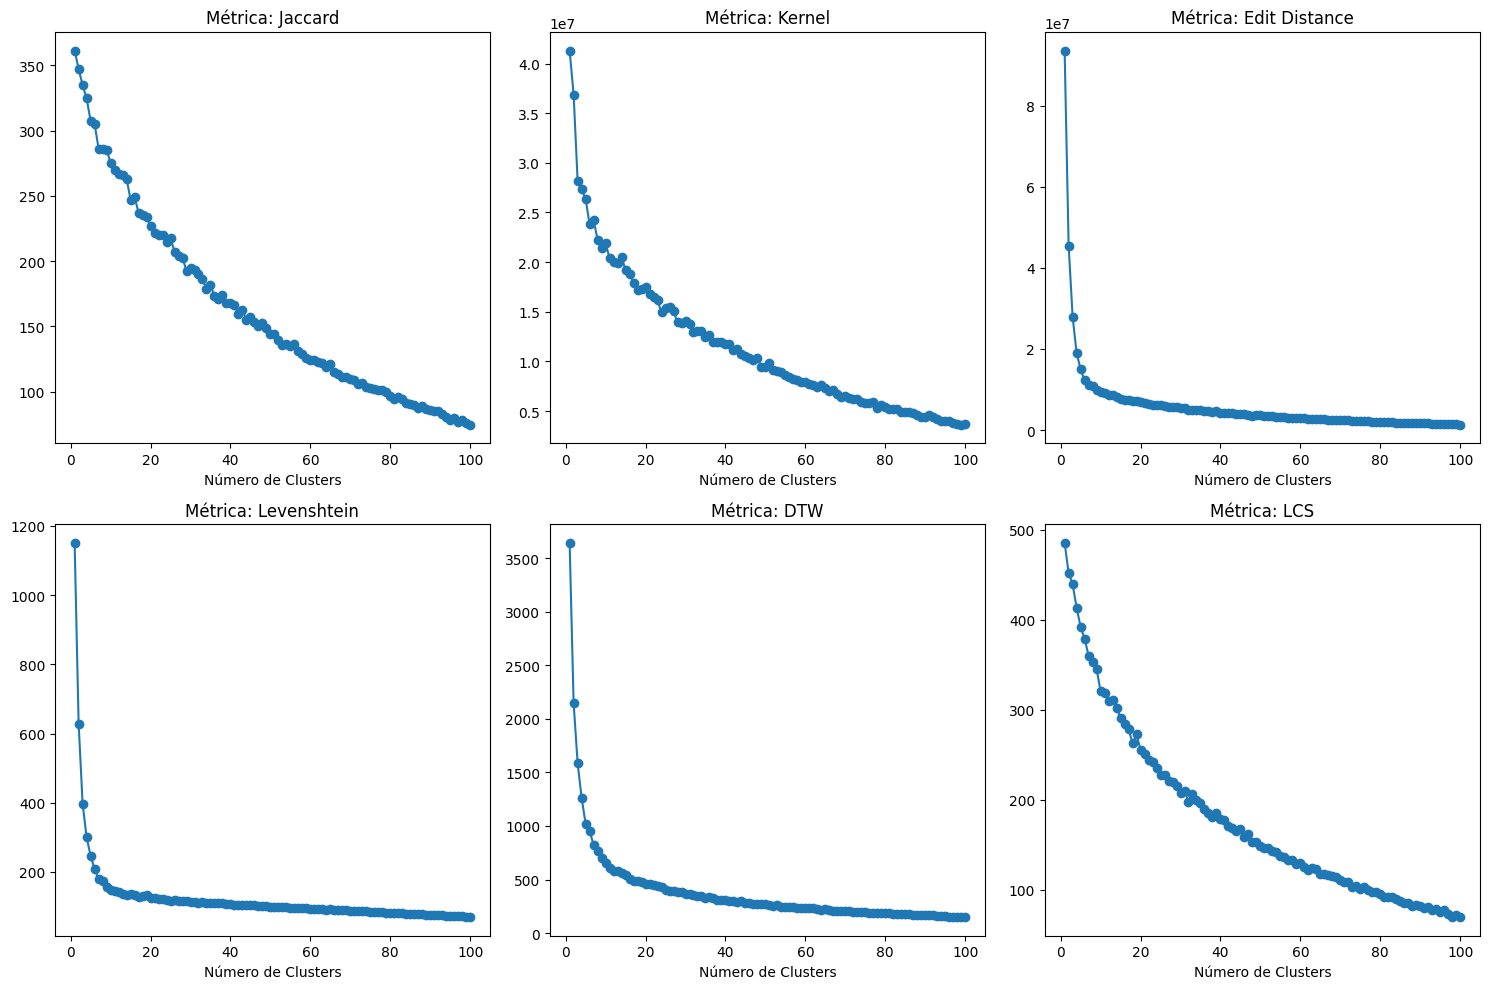

In [273]:
metrics = {
    'Jaccard': measures.jaccard_similarity, 
    'Kernel':measures.graph_kernel, 
    'SunGraph':measures.subgraph_matching, 
    'Edit Distance':measures.distancia_edit, 
    'Similaridade':measures.similaridade_grafos, 
    'DTW':measures.dtw_similarity, 
    'LCS':measures.lcs_similarity, 
    'Levenshtein':measures.levenshtein_similarity
 } # todas as metricas até o momento
teste = {
    'Jaccard':measures.jaccard_similarity, 
    'Kernel':measures.graph_kernel, 
    'Edit Distance':measures.distancia_edit, 
    'Levenshtein':measures.levenshtein_similarity, 
    'DTW':measures.dtw_similarity, 
    'LCS':measures.lcs_similarity
}
plot.elbow_method(grafos, max_clusters=100, similarity_metrics=teste)
    

In [274]:
import skfuzzy
from sklearn.metrics import silhouette_score
def get_skfuzzy_silueta(lista_grafos, max_clusters=10, min_clusters=2, similarity_metrics=None):
    if max_clusters >= len(lista_grafos):
        max_clusters = len(lista_grafos)
    skfuzzy_scores = {}
    # Inicializar a semente
    np.random.seed(42)
    for metric in similarity_metrics:
        siluetas_score = []
        fpc_scores = []
        melhor_score = -np.inf
        melhor_k = None
        X_sim = measures.matriz_similaridade(lista_grafos, func_similaridade=similarity_metrics[metric])
        list_clusters = []
        fpc_scores.append(0)
        siluetas_score.append(0)
        list_clusters.append([])
        fpc_scores.append(0)
        siluetas_score.append(0)
        list_clusters.append([])
        for k in range(min_clusters, max_clusters):
            c, m, _, d, jm, p, fpc = skfuzzy.cmeans(X_sim.T, k, 1.5, error=0.005, maxiter=1000, init=None)
            try:
                fpc_scores.append(fpc)
                silueta = silhouette_score(X_sim, m.argmax(axis=0))
                siluetas_score.append(silueta)
                list_clusters.append(m)
                # Salvar o melhor score e a matriz de pertinência correspondente
                if fpc > melhor_score:
                    melhor_score = fpc
                    melhor_k = m

            except Exception as e:
                fpc_scores.append(0)
                siluetas_score.append(0)
                list_clusters.append([])
                print(f"Erro ao calcular o Silhouette para {k} clusters: {e}")
        skfuzzy_scores[metric] = [siluetas_score, fpc_scores, list_clusters, melhor_score, melhor_k]
    return skfuzzy_scores

In [275]:
def elbow_method_fuzzy(lista_grafos, ncols=3, max_clusters=10, min_cluster=2, similarity_metrics=None):    
    skfuzzy_scores = get_skfuzzy_silueta(lista_grafos, max_clusters, min_cluster , similarity_metrics)
    n_graphs = len(lista_grafos)
    num_metrics = len(similarity_metrics)

    # Definindo um layout de 2 linhas e 3 colunas
    nrows = (num_metrics // ncols) + (num_metrics % ncols > 0)  # Calcula o número de linhas necessário

    # Criando os subgráficos
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))

    # Desempacotando o array de subgráficos para um formato mais fácil de usar
    axs = axs.flatten()

    cluster_counts = range(0, max_clusters)
    # Plotando os gráficos
    for i, metric in enumerate(similarity_metrics):
        try:
            axs[i].plot(cluster_counts, skfuzzy_scores[metric][0], marker='o', label="Coeficiente de Silhueta")
        except Exception as e:
            print(skfuzzy_scores[metric][0])
            print(e)
        try:
            axs[i].plot(cluster_counts, skfuzzy_scores[metric][1], marker='x', label="Fuzzy Partition Coefficient (FPC)")
        except Exception as e:
            print(e)
        axs[i].set_title(f'Métrica: {metric}')
        axs[i].set_xlabel('Número de Clusters')
        axs[i].legend(loc="best")  # Adiciona a legenda
        axs[i].grid(True)
    # Ajustando o layout
    plt.tight_layout()
    plt.show()

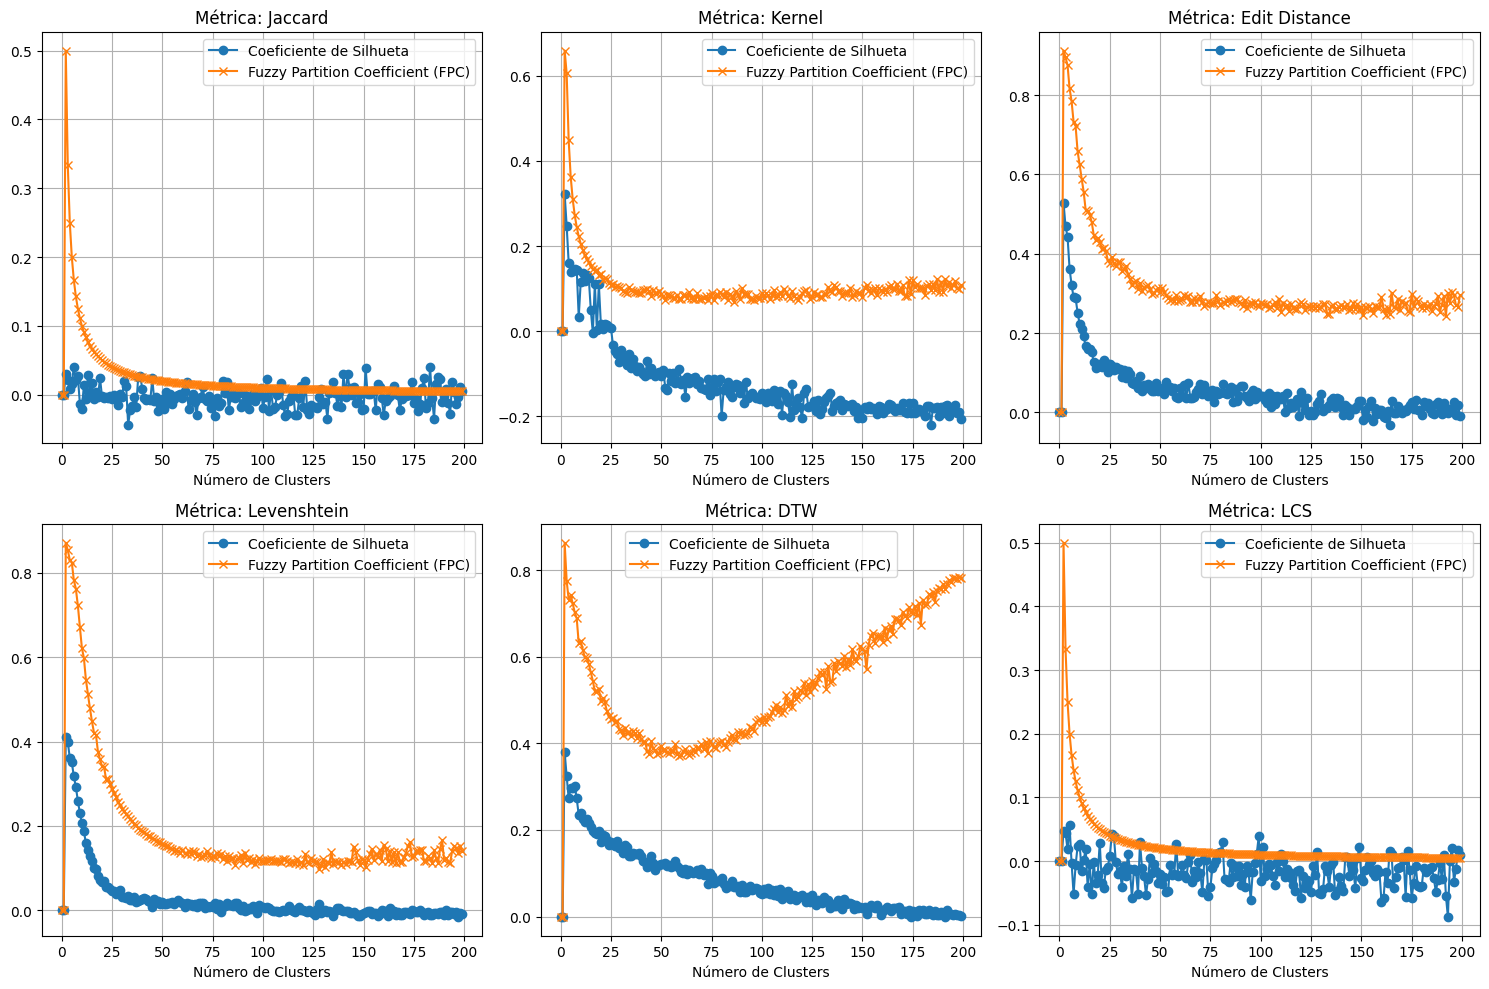

In [276]:
elbow_method_fuzzy(grafos, max_clusters=200, min_cluster=2, similarity_metrics=teste)

----------
# Contexto

## Carrega dados

### Efetua Experimentos

### Resultados

### Conclusão